## Estimation Of Variance For Single Segment 
Let's try to estimate $\sigma_I$ analytically for one segment.


$$\sigma^2_I=\left<\frac{f^2}{w^2}\right>-\left<\frac{f}{w}\right>^2$$

Let $g=\frac{f}{w}$, then,

$$\sigma^2_{f/w}=\left<g^2\right>-\left<g\right>^2\\$$


We can expand $g$ using Taylor Series around $\frac{b+a}{2}$,

$$g(x)=g\left(\frac{b+a}{2}\right)+g'\left(\frac{b+a}{2}\right)\left(x-\frac{b+a}{2}\right)+\frac{1}{2}g''\left(\frac{b+a}{2}\right)\left(x-\frac{b+a}{2}\right)^2$$

We can also aprroximate first and second derivative very accurately for a small region,

$$g'\left(\frac{b+a}{2}\right)=\frac{g(b)-g(a)}{b-a}$$

$$g''\left(\frac{b+a}{2}\right)=\frac{g(b)-2g(\frac{b+a}{2})+g(a)}{(\frac{b-a}{2})^2}$$

To simplify equations we can define the following variables,

$p=g(\frac{b+a}{2})$

$q=\frac{g(b)-g(a)}{b-a}$

$r=\frac{g(b)-2g(\frac{b+a}{2})+g(a)}{2(\frac{b-a}{2})^2}$

$u=(x-\frac{b+a}{2})$

Then,

$$g(x)=ru^2+qu+p$$

Since we forced w to be equal to f at the boundaries, q is 0.

Our job reduces to calculate 


$$\left<(ru^2+p)^2\right>-\left<ru^2+p\right>^2$$


Expanding the terms,


$$\sigma^2_{f/w}=\left<r^2u^4+2rpu^2+p^2\right>-\left<ru^2+p\right>^2$$


$$=(r^2\left<u^4\right>+2rp\left<u^2\right>+p^2)-(r^2\left<u^2\right>^2+2rp\left<u^2\right>+p^2)$$


$$=r^2\left<u^4\right> -r^2\left<u^2\right>^2 $$


$$=r^2(\left<u^4\right>-\left<u^2\right>^2)\\$$



This could further be simplified as,

$$\sigma^2_{f/w}= r^2\sigma^2_{u^2}$$

Finally $\sigma_I$ can be estimated as,

$$\sigma_I=\frac{(b-a)}{\sqrt{N}} r \sigma_{u^2}=\frac{(b-a)}{\sqrt{N}}\frac{g(b)-2g(\frac{b+a}{2})+g(a)}{2(\frac{b-a}{2})^2}\sqrt{\left(\frac{2(b-a)^4}{5\cdot2^5}-\frac{4(b-a)^4}{9\cdot2^6}\right)}$$

$$\sigma_I=\sqrt{\left(\frac{2(b-a)^2}{5\cdot 2^5}-\frac{4(b-a)^2}{9\cdot 2^6}\right)}\frac{2}{\sqrt{N}}(g(b)-2g(\frac{b+a}{2})+g(a))$$

or

$$\sigma_I=\frac{0.03727(b-a)^3}{\sqrt{N}}g''\left(\frac{a+b}{2}\right)$$



In [23]:
import numpy as np
from numpy.polynomial import Polynomial as P
#import plotly
#import plotly.plotly as py
#import plotly.figure_factory as ff
import matplotlib.pyplot as plt
#Integrand function
def f(x,H):
    return (x-5)*np.exp(-(x/2-3))+H

#Calculates the coefficients of linear weight function.    
def findw(f,H,lower,upper,normalize):
    #Find the linear function.
    slope=(f(upper,H)-f(lower,H))/(upper-lower)
    a=slope
    b=-slope*upper+f(upper,H)
    #Normalization.
    A=(a/2)*(upper**2)+b*upper-(a/2)*(lower**2)-b*lower
    if normalize:
        a/=A
        b/=A
    return [a,b]
#Performs integration.
def integrate(f,lower,upper,N,C):
    H=C
    w=findw(f,H,lower,upper,True)    
    #Generate uniform random inputs.
    inputs=np.random.rand(N)    
    a=w[0]/2  
    b=w[1]
    c=-(a*lower**2+b*lower)
    
    SUM=0
    SUM2=0
    
    inverse_inputs=[]
    for i in inputs:
        p=[(-b-np.sqrt(b**2-4*a*(c-i)))/(2*a),(-b+np.sqrt(b**2-4*a*(c-i)))/(2*a)]
        if p[0]>=lower and p[0]<=upper:
            inverse_inputs.append(p[0])
        else :
            inverse_inputs.append(p[1])

    inverse_inputs=np.array(inverse_inputs)
    #Calculate f(inverse(x))/w(inverse(x)).
    outputsF=f(inverse_inputs,H)
    outputsW=w[0]*(inverse_inputs)+w[1]
    outputs=outputsF/outputsW
    SUM=outputs.sum()
    SUM2=(outputs*outputs).sum()
    var=SUM2/N-(SUM/N)**2
    var=var/N
    #Store generated points for variance calculation.
    Vsum=outputs.sum()
    return Vsum/N-H*(upper-lower),(upper-lower)**2*var
    



def theoretical_sigma(f,lower,upper,N,C):
    
    w=findw(f,C,lower,upper,True) 
    
    flower=f(lower,C)
    fmiddle=f((lower+upper)/2,C)
    fupper=f(upper,C)
    
    wlower=w[0]*lower+w[1]
    wmiddle=w[0]*(lower+upper)/2+w[1]
    wupper=w[0]*upper+w[1]
    
    gupper=fupper/wupper
    gmiddle=fmiddle/wmiddle
    glower=flower/wlower    

    
    sigma=np.abs(0.03727*(upper-lower)**3/np.sqrt(N)*(4*(gupper-2*gmiddle+glower)/(upper-lower)**2))
    
    
    #return (upper-lower)*np.sqrt(var)
    return sigma

low=4.6
up=5.2
#Divide the region into 10 pieces.
l=[low,up]   
#Real value of the integral
I_real=-.12002
#N values
N=[100,500,1000,5000,10000,50000,100000]
#Integration results.
results=[]
#Standart deviation values
sigmas=[]
theory_sigmas=[]
print('N','   sigma_exp','       sigma_theory','    sigma_theory/sigma_exp')

for k in N:
    I=0
    sigma=0
    S=1000
    for i in range (0,len(l)-1):
        temp_sigma=[]
        for j in range(0,10):
            I=0
            sigma=0
            temp,temp2=integrate(f,l[i],l[i+1],k,S)
            I+=temp
            sigma+=temp2
            temp_sigma.append(np.sqrt(sigma))
    results.append(I)
    sigmas.append(np.mean(temp_sigma))
    theory_sigmas.append(theoretical_sigma(f,low,up,k,S))
    sigma=np.mean(temp_sigma)
    print(k,sigma,theoretical_sigma(f,low,up,k,S),theoretical_sigma(f,low,up,k,S)/sigma)    

N    sigma_exp        sigma_theory     sigma_theory/sigma_exp
100 0.000876274045448 0.000861306634305 0.982919257714
500 0.000382733216776 0.000385188036756 1.00641391934
1000 0.000272760056223 0.000272369072822 0.998566566504
5000 0.000122492530038 0.00012180715236 0.994404738982
10000 8.63306816331e-05 8.61306634305e-05 0.997683115681
50000 3.86083629727e-05 3.85188036756e-05 0.997680313531
100000 2.73145698375e-05 2.72369072822e-05 0.997156735185


Here N is the total number of sample points, sigma_exp is the mean of the experimental sigmas, sigma_theory is analytical estimation of sigma and the last columns is the ratio of there two. The ratio is very close to 1, this means analytical estimation is reasonable.

Let's plot analytical sigma with N=1000.

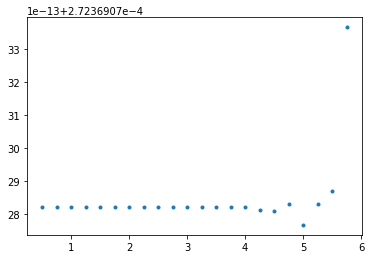

In [58]:
C=np.arange(0.5,6,0.25)
analytic=[]
experimental=[]
low=4.6
up=5.2
#Divide the region into 10 pieces.
l=[low,up]  
for k in C:
    sigma=0
    S=10**k
    temp_sigma=[]
    for i in range (0,len(l)-1):
        for j in range(0,10):
            sigma=0
            temp,temp2=integrate(f,l[i],l[i+1],1000,S)
            I+=temp
            sigma+=temp2
            temp_sigma.append(np.sqrt(sigma))
    sigma=np.mean(temp_sigma)
    experimental.append(sigma)
    analytic.append(theoretical_sigma(f,low,up,1000,S))
plt.plot(C,analytic,'.')
plt.show()